# Symbolic Explanations on the Mutagenicity Dataset


### Load the packages, data and model

In [ ]:
%autoreload 2

from symbxai.visualization.plot_mutag import get_molecule_plot_info
from symbxai.dataset.load_mutag import load_dataset
from functools import reduce

from rdkit.Chem import Draw
from rdkit import Chem

dataset_name = 'Mutagenicity'
dataset = load_dataset(dataset_name)

import pandas as pd
substructures_df = pd.read_csv('data/Mutagenicity_substructure.csv', delimiter='&')

from symbxai.model.utils import load_best_model
model = load_best_model('biasedMutagenicity') # _GIN_1731595245


debug = False
rule_linear = 'gamma'
gamma = 0.2
from symbxai.dataset.load_mutag import get_substructure_match
from symbxai.visualization.plot_mutag import plot_substructure_match
from symbxai.lrp.symbolic_xai import MutagenicitySymbXAI
from symbxai.utils import powerset
import matplotlib.pyplot as plt
from functools import reduce 


# Configure LaTeX settings
plt.rcParams.update({
    "text.usetex": True,  # Enable LaTeX rendering
    "pgf.preamble": r"""
        \usepackage{graphicx}
    """
})


def find_substructure(molecule,substructure_name, substructures_df, plot=False):
    substructure_smarts = substructures_df[substructures_df['name']==substructure_name]['smarts'].values[0]
    substr_idx = get_substructure_match(molecule, substructure_smarts)
    if substr_idx is None:
        return False
    else: 
        if plot:
            print(substructure_name)
            plot_substructure_match(molecule, substr_idx)
        return {substructure_name: sorted(substr_idx)}
    

def obtatin_intersting_subtr_indices(interesting_substructures, molecule, substructures_df):
    mol_substructures = {}
    for substr_name in interesting_substructures: 
        substr_dict = find_substructure(molecule,substr_name , substructures_df, plot=False)
        if substr_dict:
            mol_substructures.update(substr_dict)

    # Aggregate all indices present in the dictionary
    all_indices = set(index for indices in mol_substructures.values() for index in indices)
    # Determine the missing indices
    missing_indices = set(range(molecule.GetNumAtoms())) - all_indices
    # Update the dictionary with the missing indices
    mol_substructures['rest'] = sorted(missing_indices)

    return mol_substructures, len(mol_substructures) == (len(interesting_substructures) +1)

/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded model biasedMutagenicity_GIN_1701953871.pth with test accuracy 0.8456


## search for some samples

In [2]:
substr_combination_names = [('Specific aromatic nitro', 'Sulfonamide'),
                            ('Specific aromatic amine', 'Sulfonamide'), 
                            ('Specific aromatic nitro',), 
                            ('Specific aromatic amine',), 
                            ('Sulfonamide',), 
                            ('Sulfonic Acid Group',),
                            ('Specific aromatic nitro', 'Trifluoromethyl Group'),
                            ('Specific aromatic nitro', 'Arylsulfonyl Derivatives'), 
                            ('Specific aromatic nitro', 'Sulfonic Acid Group')]
all_considered_substructures = tuple(set(reduce (lambda x,y : x + y , substr_combination_names)))
print(all_considered_substructures)


mol_idx_by_substr_comb = {sc_name : [] for sc_name in substr_combination_names}

for idx in range(len(dataset)):
    sample = dataset[idx]
    plot_info = get_molecule_plot_info(sample, 
                                        dataset_name=dataset_name,
                                        info_list=['pos', 'node_label_dict', 'bond_type_dict'])
    molecule = plot_info['molecule']
    Chem.SanitizeMol(molecule)
    
    for substr_combination in substr_combination_names:
        substr_combination_compliment = tuple([name for name in all_considered_substructures if name not in substr_combination ])

        # Check if all substructures in the combination are found
        sub_combination_found = all(
            bool(find_substructure(molecule, substr_name, substructures_df, plot=False))
            for substr_name in substr_combination
        )

        # Check if all substructures in the complement are not found
        sub_combination_complement_not_found = all(
            not bool(find_substructure(molecule, substr_name, substructures_df, plot=False))
            for substr_name in substr_combination_compliment
        )

        # Combine the conditions in the if clause
        if sub_combination_found and sub_combination_complement_not_found:
            mol_idx_by_substr_comb[substr_combination].append(idx)
        
    # for substr_combination in substr_combination_names:
    #     if all([bool(find_substructure(molecule,substr_name , substructures_df, plot=False)) for substr_name in substr_combination]) and all([ not bool( find_substructure(molecule, substr_name, substructures_df, plot=False)) for substr_name in substr_combination_names_compliment ]):
    #             mol_idx_by_substr_comb[substr_combination].append(idx)




('Specific aromatic nitro', 'Sulfonamide', 'Specific aromatic amine', 'Sulfonic Acid Group', 'Trifluoromethyl Group', 'Arylsulfonyl Derivatives')


In [3]:
model

GIN(
  (act): ReLU(inplace=True)
  (gin): Sequential(
    (0) - GINConv(nn=MLP(14, 64, 64)): x, edge_index -> x
    (1) - ReLU(inplace=True): x -> x
    (2) - GINConv(nn=MLP(64, 64, 64)): x, edge_index -> x
    (3) - ReLU(inplace=True): x -> x
    (4) - GINConv(nn=MLP(64, 64, 64)): x, edge_index -> x
    (5) - ReLU(inplace=True): x -> x
  )
  (linear): Linear(in_features=64, out_features=2, bias=True)
)

In [4]:
for key, vals in mol_idx_by_substr_comb.items():
    print(key, len(vals))

('Specific aromatic nitro', 'Sulfonamide') 1
('Specific aromatic amine', 'Sulfonamide') 6
('Specific aromatic nitro',) 563
('Specific aromatic amine',) 290
('Sulfonamide',) 17
('Sulfonic Acid Group',) 57
('Specific aromatic nitro', 'Trifluoromethyl Group') 5
('Specific aromatic nitro', 'Arylsulfonyl Derivatives') 0
('Specific aromatic nitro', 'Sulfonic Acid Group') 7


## Visualize a few samples

molecule ID: 262
Specific aromatic amine
Sulfonamide
rest


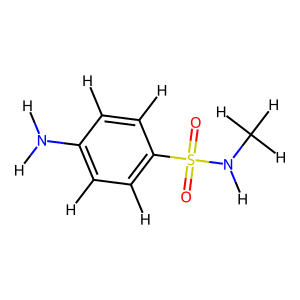

molecule ID: 834
Specific aromatic amine
Sulfonamide
rest


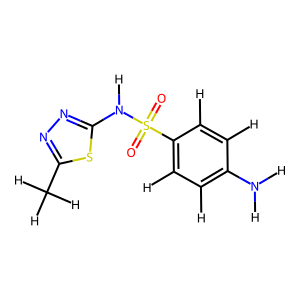

molecule ID: 1552
Specific aromatic amine
Sulfonamide
rest


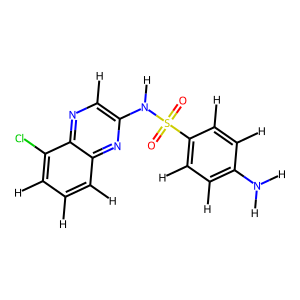

molecule ID: 1639
Specific aromatic amine
Sulfonamide
rest


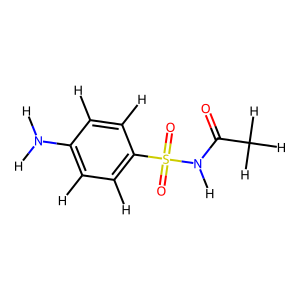

molecule ID: 2951
Specific aromatic amine
Sulfonamide
rest


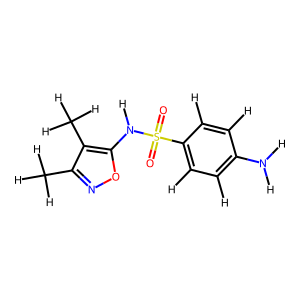

molecule ID: 3561
Specific aromatic amine
Sulfonamide
rest


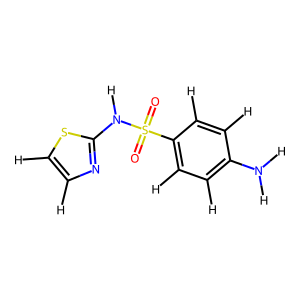

In [5]:
nb_vis = 7
interesting_substructures = ('Specific aromatic amine', 'Sulfonamide')

for idx in mol_idx_by_substr_comb[interesting_substructures][:nb_vis]:
    sample = dataset[idx]
    if sample.x.shape[0] != len(set(sample.edge_index[0].numpy())): # This is just a dataspecific bug
        print('not for', idx)
        # nbs_of_errors += 1
        continue
    plot_info = get_molecule_plot_info(sample, 
                                        dataset_name=dataset_name,
                                        info_list=['pos', 'node_label_dict', 'bond_type_dict'])
    molecule = plot_info['molecule']
    Chem.SanitizeMol(molecule)

    mol_substructures, _  = obtatin_intersting_subtr_indices(interesting_substructures, molecule, substructures_df)

    print('molecule ID:', idx)
    for substr_name, substr_idx in mol_substructures.items():
        print(substr_name)
        # plot_substructure_match(molecule, substr_idx)
    
    plot_substructure_match(molecule, [])
    

### Consider a specific molecule

In [6]:

import seaborn as sns
import pandas as pd
orange = (.8, 0.5, 0.0)
light_green = (0.5, .85, 0.5)
green = (0.0, 0.5, 0.0)
from symbxai.visualization.utils import make_boxplots_with_stripplots



/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


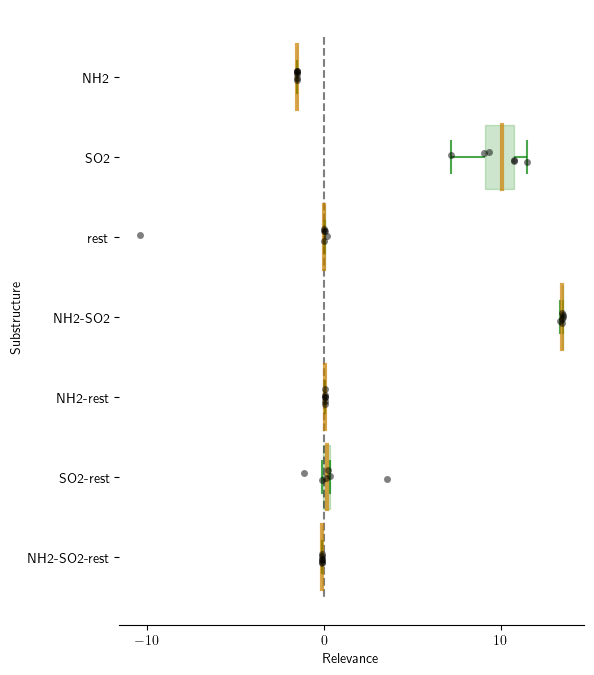

we skipted 0 samples from 6
{'NH2': [tensor(-1.5574), tensor(-1.5574), tensor(-1.5574), tensor(-1.5574), tensor(-1.5574), tensor(-1.5574)], 'SO2': [tensor(7.1409), tensor(9.0401), tensor(11.4844), tensor(10.7316), tensor(10.7316), tensor(9.3310)], 'rest': [tensor(0.), tensor(0.), tensor(-10.3760), tensor(0.), tensor(0.1589), tensor(0.0680)], 'NH2-SO2': [tensor(13.3335), tensor(13.4988), tensor(13.4843), tensor(13.4354), tensor(13.4354), tensor(13.4099)], 'NH2-rest': [tensor(0.0394), tensor(0.0394), tensor(0.0394), tensor(0.0394), tensor(0.0394), tensor(0.0394)], 'SO2-rest': [tensor(-0.1251), tensor(-1.1468), tensor(3.5587), tensor(0.2290), tensor(0.3275), tensor(0.0887)], 'NH2-SO2-rest': [tensor(-0.1198), tensor(-0.1146), tensor(-0.1251), tensor(-0.1182), tensor(-0.1182), tensor(-0.1146)]}


In [7]:
plot_names = {
    'Specific aromatic nitro': 'NO2',
        'Specific aromatic amine': 'NH2',
        'Sulfonamide' : 'SO2', 
       'Sulfonic Acid Group': 'SO3', 
       'Trifluoromethyl Group': 'CF3',
        'rest': 'rest'
    }

# for interesting_substructures in [ ('Specific aromatic nitro', 'Trifluoromethyl Group')]:#, ('Sulfonamide',), ('Specific aromatic amine',), ]: #  # ['Specific aromatic nitro',  'Specific aromatic amine', 'Sulfonamide', ]
if interesting_substructures == ('Specific aromatic amine', 'Sulfonamide'):
    observed_class = 1
    plot_extent='SO2_NH2'
    all_concepts = ['SO2', 'NH2', 'rest']
elif interesting_substructures == ('Specific aromatic amine',):
    observed_class = 0
    plot_extent = 'NH2'
    all_concepts = [ 'NH2', 'rest']
elif interesting_substructures == ('Sulfonamide',):
    observed_class = 1
    plot_extent = 'SO2'
    all_concepts = ['SO2', 'rest']
elif interesting_substructures ==  ('Specific aromatic nitro', 'Sulfonic Acid Group'):
    observed_class = 1
    plot_extent = 'NO2_SO3'
    all_concepts = ['NO2', 'SO3', 'rest']
elif interesting_substructures ==  ('Specific aromatic nitro', 'Trifluoromethyl Group'):
    observed_class = 1
    plot_extent = 'NO2_CF3'
    all_concepts = ['NO2', 'CF3', 'rest']
else:
    raise NotImplementedError

intersting_indices = mol_idx_by_substr_comb[interesting_substructures] # [428, 262, 834, 1552, 1639, 2951, 3561] # [67,283,910,1064,1228,1248,1692,1832,1890,2072,2373,2621,3103,3286,3724,4063,4322 ]

plot_samples = [] #range(len(dataset)) #[]

######### 

nbs_of_errors = 0
all_rels = {}
for idx in intersting_indices:
    sample = dataset[idx]
    if sample.x.shape[0] != len(set(sample.edge_index[0].numpy())): # This is just a dataspecific bug
        print('not for', idx)
        nbs_of_errors += 1
        continue
    plot_info = get_molecule_plot_info(sample, 
                                        dataset_name=dataset_name,
                                        info_list=['pos', 'node_label_dict', 'bond_type_dict'])
    molecule = plot_info['molecule']
    Chem.SanitizeMol(molecule)
    

    if model(sample.x, sample.edge_index).argmax() != sample.y:
        print('for ID:', idx, 'model predicted', model(sample.x, sample.edge_index).argmax().item(), 'but the label is', sample.y.item() )
        # nbs_of_errors += 1
        # continue
    if observed_class is not None and sample.y != observed_class:
        print('for ID:', idx, 'the ground truth is', sample.y.item(), ' but we expected it to be ', observed_class )
        # nbs_of_errors += 1
        # continue
    

    mol_substructures, _  = obtatin_intersting_subtr_indices(interesting_substructures, molecule, substructures_df)
    
    explainer = MutagenicitySymbXAI(sample,
                        model,
                        gamma=gamma,
                        scal_val=1.,
                        target_class= None,
                        debug = False)

    substr_pset = powerset(mol_substructures.keys())

    for i, subst_names in enumerate(substr_pset):
        curr_substrs = [mol_substructures[name] for name in subst_names]
        rel = explainer.harsanyi_div(curr_substrs)
        reduc_name = reduce(lambda x,y: x + '-' + y, [plot_names[name] for name in subst_names] )
        
        # print(subst_names, rel, reduc_name)
        if reduc_name in all_rels.keys():
            all_rels[reduc_name] += [rel]
        else:
            all_rels[reduc_name] = [rel]

    if idx in plot_samples:
        display(Draw.MolToImage(molecule))
        plt.figure(figsize=(15,2))
        plt.bar( all_rels.keys() ,
                [rels[-1] for rels in all_rels.values()],
                color=['red' if rels[-1]>0 else 'blue' for rels in all_rels.values()])
        plt.show()
        print('prediction is:', 'non-mutagenic' if  1 == model(sample.x, sample.edge_index).argmax() else 'mutagenic',  model(sample.x, sample.edge_index).detach().numpy())
        print('ground-truth is:', 'non-mutagenic' if  1 == sample.y else 'mutagenic') 

# fig, ax = plt.subplots(figsize=(10,4))


# Assuming 'all_rels' is your dictionary of data
data = []
for key, values in all_rels.items():
    for value in values:
        data.append({'Substructure': key, 'Relevance': value.item()})
# Convert to DataFrame
    
make_boxplots_with_stripplots(data, 
                              plot_extent=None, # or some name
                               outlier_quantile=.0,
                               add_vline=True,

                                figsize=(6,8))
print('we skipted', nbs_of_errors, 'samples from', len(intersting_indices))
print(all_rels)

## Explaining queries

In [8]:
from symbxai.utils import Query_from_promt

In [9]:
# from itertools import product
from functools import reduce
from copy import copy


import re

from symbxai.query_search.utils import generate_promts


all_neg_and_pos_concepts = copy(all_concepts)


all_neg_and_pos_concepts += generate_promts(all_input_promts=all_concepts,
                modes=[
                    'negation of promts'
                ])

all_multi_order_conj = generate_promts(all_input_promts=all_neg_and_pos_concepts,
            modes=[
                f'conjuction of order {order} between promts'  for order in range(2,4)
            ])

all_implications = generate_promts(all_input_promts=all_concepts,
                             modes=[
                                 'implication between promts'
                             ])
all_implications_conj_neg_pos_concepts = generate_promts(all_input_promts=all_implications,
                             more_input_promts=all_neg_and_pos_concepts,
                             modes=[
                                 'conjoin different promts with each other'
                             ])

all_promts = all_neg_and_pos_concepts + all_multi_order_conj + all_implications + all_implications_conj_neg_pos_concepts


len(all_promts)

44

we analyse 35 queries.


/opt/homebrew/Caskroom/miniconda/base/envs/symbxai/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


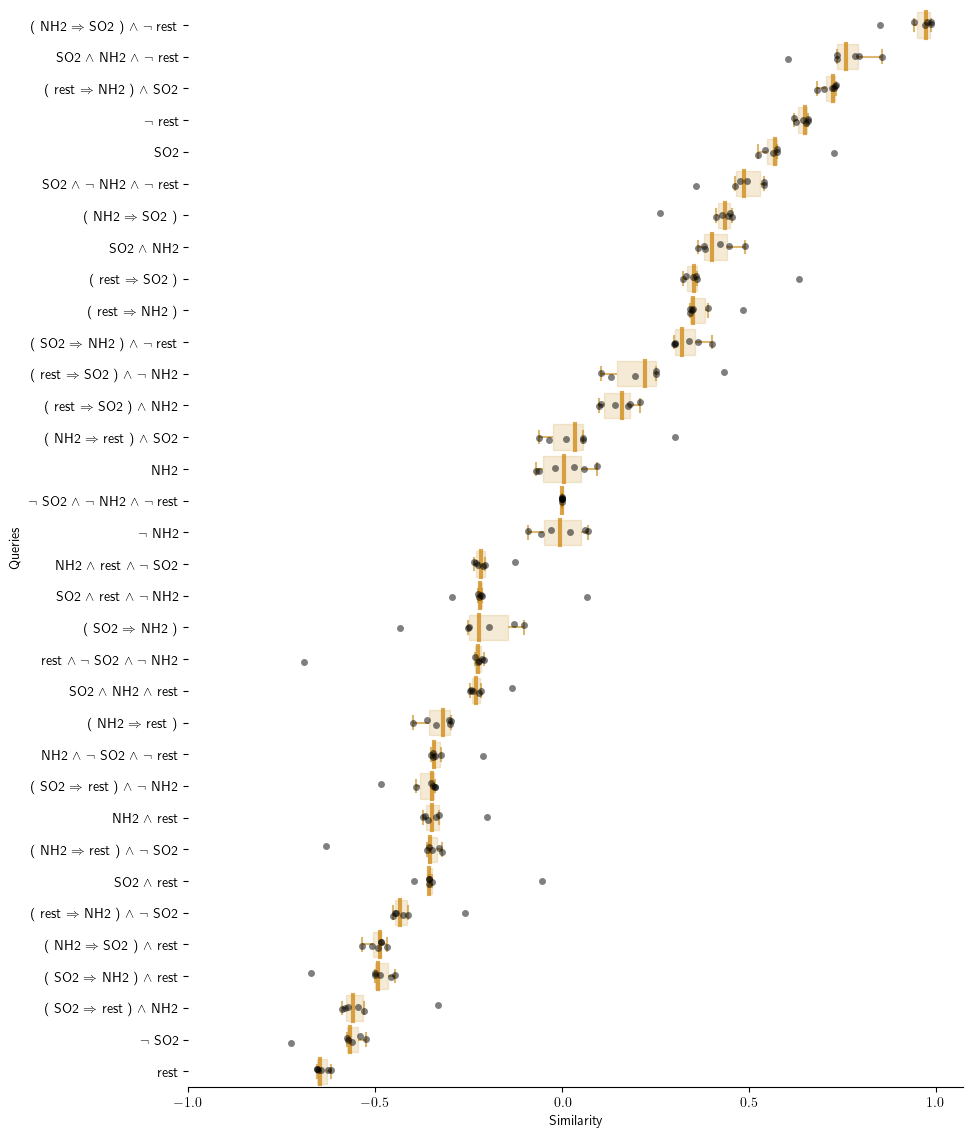

In [10]:
import numpy as np
from symbxai.query_search.utils import corr 
from statistics import median
from symbxai.query_search.utils import remove_semantic_duplicate_queries

def make_latex_rep(promt):
    latex_rep = copy(promt)
    latex_rep = latex_rep.replace('AND', '$\\wedge$')
    latex_rep = latex_rep.replace('NOT', '$\\neg$')
    latex_rep = latex_rep.replace('OR', '$\\vee$')
    latex_rep = latex_rep.replace('IMPLIES', '$\\Rightarrow$')
    return latex_rep


# interesting_substructures = ('Specific aromatic nitro', 'Trifluoromethyl Group')
all_query_promts = remove_semantic_duplicate_queries(all_promts[::-1], all_concepts, verbose=False) #['NH2 AND SO2', 'NH2 AND NOT SO2', 'NOT NH2 AND SO2', 'NH2 AND rest', 'SO2 AND rest', 'SO2 IMPLIES NH2', 'NH2 IMPLIES SO2', 'SO2', 'SO2 AND NOT rest', '( NH2 IMPLIES SO2 ) AND NOT rest']

print(f'we analyse {len(all_query_promts)} queries.')

plot_samples = False 
plot_extent2 = 'queries_all'
nb_max_queries = -1
result_mode =  'Similarity' #  'Relevance' 

concept_names = {
    'Specific aromatic nitro': 'NO2',
    'Sulfonic Acid Group' : 'SO3',
    'Specific aromatic amine': 'NH2',
    'Sulfonamide' : 'SO2', 
    'Trifluoromethyl Group': 'CF3',
    'rest': 'rest'
}

query_attributions = {promt: [] for promt in all_query_promts}
filter_vectors = {}
multi_order_vectors = {}
for idx in mol_idx_by_substr_comb[interesting_substructures]:
    for query_promt in all_query_promts:

        sample = dataset[idx]

        plot_info = get_molecule_plot_info(sample, 
                                            dataset_name=dataset_name,
                                            info_list=['pos', 'node_label_dict', 'bond_type_dict'])

        molecule = plot_info['molecule']
        Chem.SanitizeMol(molecule)

        mol_substructures, success  = obtatin_intersting_subtr_indices(interesting_substructures, molecule, substructures_df)

        if not success: print('something went wrong here')

        explainer = MutagenicitySymbXAI(sample,
                                    model,
                                    gamma=gamma,
                                    scal_val=1.,
                                    target_class= None,
                                    debug = False)

        

        concept2ids = {concept_names[concept]: subset for concept, subset in mol_substructures.items()}

        substr_pset = powerset(concept2ids.values())
            
        query = Query_from_promt(
            promt=query_promt,
            concept2ids=concept2ids, 
            str_rep=None
        )

        filter_vector = query.get_filter_vector(substr_pset)
        multi_order_vector = [explainer.harsanyi_div(subsets) for subsets in substr_pset]

        multi_order_vectors[query_promt] = multi_order_vector
        filter_vectors[query_promt]= filter_vector

        if result_mode == 'Relevance':
            query_attributions[query_promt] += [np.dot(filter_vector,multi_order_vector)]
            plot_color = (0.5, 0.0, 0.5) 
            xticks=[-30, -20]
        elif result_mode == 'Similarity':
            query_attributions[query_promt] += [corr(np.array(filter_vector),np.array(multi_order_vector))]
            plot_color = (0.8, .6, 0.2)
            xticks = [-1,-.5,0,.5,1]
        else:
            raise ValueError(f'result_mode = {result_mode} is not a valid input.')

    if plot_samples:
        display(Draw.MolToImage(molecule))
        plt.figure(figsize=(15,2))
        plt.bar( query_attributions.keys(),
                        [rels[-1] for rels in query_attributions.values()],
                        color=['red' if rels[-1]>0 else 'blue' for rels in query_attributions.values()])
        plt.show()

sorted_query_attributions = dict(
    sorted(query_attributions.items(), key=lambda item: median(item[1]))
)

data = []
for key, values in list(sorted_query_attributions.items())[::-1][:nb_max_queries]:
    for value in values:
        data.append({'Queries': make_latex_rep(key), result_mode: value})

# Convert to DataFrame
make_boxplots_with_stripplots(data, 
             plot_extent=None, # or plot_extent2 + '_' +plot_extent + '_' + result_mode, 
             figsize=(10,14), 
             boxcolor=plot_color,
             outlier_quantile=0,
             xticks = xticks)
